# Temporal Fluctuations

### Issue

Neural oscillations are often variable through time (bursty). 

This can exhibit can exhibit as power differences, if temporal variability is not considered and addressed.

### Solution

If and when oscillations are or may be bursty, burst detection can be used to identify times in which the oscillation is present. 

This can be used to restrict analyses to segments in which the oscillation is present, upon which measures of interest can be computed. 

### Related Work

The following papers include discussion of this topic:
- [Shin et al, 2017](https://doi.org/10.7554/eLife.29086.001)
    - "The rate of transient beta frequency events predicts behavior across tasks and species"
- [Zich et al, 2020](https://doi.org/10.1016/j.tics.2020.07.004)
    - "Dissecting Transient Burst Events"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.plts.spectra import plot_spectra_shading
from fooof.utils import trim_spectrum

from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_bursts

## Functions

In [2]:
def _set_lr_spines(ax, lw=None):
    """Set the spines to drop top & right box & set linewidth."""

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    if lw:
        ax.spines['left'].set_linewidth(lw)
        ax.spines['bottom'].set_linewidth(lw)
        
def plot_bar(d1, d2, labels=None, err=None):
    
    _, ax = plt.subplots()
    
    if err:
        err = [np.nanstd(d1), np.nanstd(d2)]
    
    ax.bar([0.5, 1.5], [avg_func(d1), avg_func(d2)], yerr=err,
           width=0.65, tick_label=labels, alpha=0.9)

    ax.set_xlim([0, 2])
    
    ax.set_yticks([]);
    if not labels: ax.set_xticks([]);
    
    _set_lr_spines(ax, 4)

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Define general simulation settings
n_seconds = 100
fs = 1000

times = create_times(n_seconds, fs)

In [6]:
# Set the function for averaging
avg_func = np.nanmedian

In [7]:
# Define parameters for the simulations
cf = 10
exp = -2.
ap_filt = (1, 100)

enter1 = 0.4
leave1 = 0.2

enter2 = 0.2
leave2 = 0.4

In [8]:
# Collect parameters and set up simulations
comps1 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
          'sim_bursty_oscillation' : {'freq' : cf, 'enter_burst' : enter1, 'leave_burst' : leave1}}
comps2 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
          'sim_bursty_oscillation' : {'freq' : cf, 'enter_burst' : enter2, 'leave_burst' : leave2}}

# Define relative power of the signal components
comp_vars = [1, 0.75]

In [9]:
# Define frequency ranges of interest
alpha_range = (8, 12)
psd_range = [2, 40]

In [10]:
# Define some plot settings
plt_kwargs = {'xlim' : [0, 10], 'xlabel' : '', 'ylabel' : ''}
labels = ['high-burst', 'low-burst']

In [11]:
alpha_color = '#1882d9'

### Simulate Time Series

For this comparison, we will simulate and compare two example signals. 

Each time series will contain a bursty alpha oscillation, but the two signals will vary in their burst probability.

In [12]:
# Simulate the example signals
sig1 = sim_combined(n_seconds, fs, comps1, comp_vars)
sig2 = sim_combined(n_seconds, fs, comps2, comp_vars)

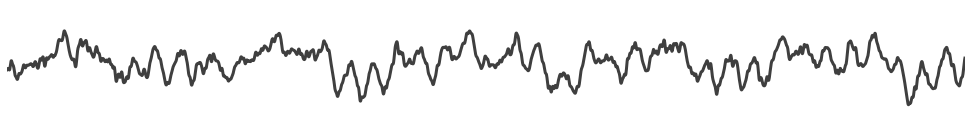

In [13]:
# Plot the first signal: high burst probability
plot_time_series(times, sig1, xlim=[0, 4], alpha=0.75)
plt.axis('off')
plt.savefig('figures/04-burst_high.pdf', bbox_inches='tight')

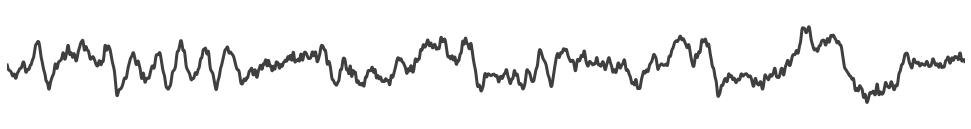

In [14]:
# Plot the first signal: low burst probability
plot_time_series(times, sig2, xlim=[0, 4], alpha=0.75)
plt.axis('off')
plt.savefig('figures/04-burst_low.pdf', bbox_inches='tight')

### Compare the Power Spectra

Next, let's compare the power spectra of the two example signals.

In [15]:
# Compute power spectra of each signal
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs), psd_range)

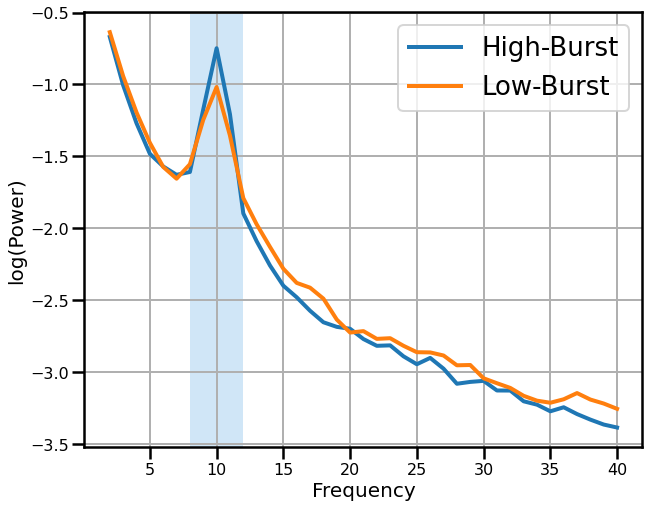

In [16]:
# Plot the power spectra, comparing between signals
plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['High-Burst', 'Low-Burst'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=alpha_color)
plt.legend(prop={'size': 26})
plt.savefig('figures/04-burst_psd.pdf', bbox_inches='tight')

Based simply on the power spectra, it looks like our two signals have a clear difference in alpha power. 

### Apply Burst Detection

By construction, we know our simulated signals have temporal variability in their oscillations. 

To dig into this, let's apply burst detection to try and measure when, in time, the oscillations are present. 

Note: here we are using burst detection using the 
[dual-amplitude](https://neurodsp-tools.github.io/neurodsp/auto_tutorials/burst/plot_BurstDetection.html)
algorithm.

In [17]:
# Apply burst detection to the first signal (high burst probability)
bursting1 = detect_bursts_dual_threshold(sig1, fs, (0.35, 1), alpha_range)

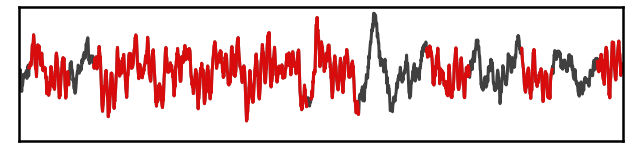

In [18]:
# Plot a segment of burst detection on the first signal
_, ax = plt.subplots(figsize=(10, 3))
plot_bursts(times, sig1, bursting1, **plt_kwargs, alpha=[0.75, 0.8], ax=ax)
plt.xticks([]); plt.yticks([]);
plt.savefig('figures/04-burst_det1.pdf', bbox_inches='tight')

In [19]:
# Apply burst detection to the first signal (low burst probability)
bursting2 = detect_bursts_dual_threshold(sig2, fs, (0.65, 0.75), alpha_range)

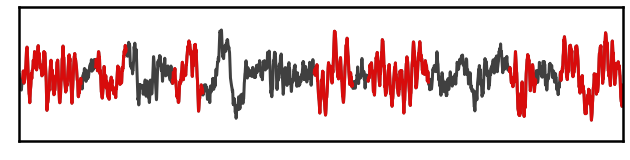

In [20]:
# Plot a segment of burst detection on the first signal
_, ax = plt.subplots(figsize=(10, 3))
plot_bursts(times, sig2, bursting2, **plt_kwargs, alpha=[0.75, 0.8], ax=ax)
plt.xticks([]); plt.yticks([]);
plt.savefig('figures/04-burst_det2.pdf', bbox_inches='tight')

In the above we can see, as expected the two signals differ in the prominence of the bursting.

### Compare Oscillatory Power

Now that we have identified the bursts, we can compare the power of the oscillation across the whole signal, to the power of the oscillations during moments of bursting. 

In [21]:
# Calculate instantaneous amplitude of each signal
amp1 = amp_by_time(sig1, fs, alpha_range)
amp2 = amp_by_time(sig2, fs, alpha_range)

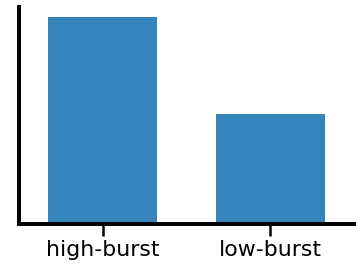

In [22]:
# Plot the comparison of total power between signals
plot_bar(amp1, amp2, labels)
plt.savefig('figures/04-bar_oscpow.pdf', bbox_inches='tight')

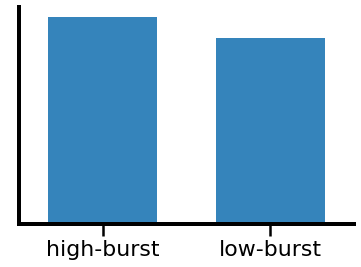

In [23]:
# Plot the comparison of burst power between signals
plot_bar(amp1[bursting1], amp2[bursting2], labels)
plt.savefig('figures/04-bar_burstpow.pdf', bbox_inches='tight')

In [24]:
# Check the difference in power, across the whole signal
print('High Burst Signal - total power : {:1.2f}'.format(avg_func(amp1)))
print('Low  Burst Signal - total power : {:1.2f}'.format(avg_func(amp2)))

High Burst Signal - total power : 0.77
Low  Burst Signal - total power : 0.41


In [25]:
# Check the difference in power, for identified burst segments
print('High-Burst Signal - burst power : {:1.2f}'.format(avg_func(amp1[bursting1])))
print('Low -Burst Signal - burst power : {:1.2f}'.format(avg_func(amp2[bursting2])))

High-Burst Signal - burst power : 0.87
Low -Burst Signal - burst power : 0.78


### Conclusions

In the above, we saw that the two simulated signals appeared to have different amounts of alpha power. 

Note that a common interpretation of a change in power is often that the magnitude of the oscillations has changed. 

In this scenario, that would be an inaccurate interpretation. 

As we can see from applying burst detection, the power of the oscillations _when they are present_ is equal. 

This shows how differences in temporal variability can look like power differences. 

Applying burst detection can help address this potential issue. 

As well as being important to check as a control, temporal variability itself may be an interest measure of interest. 